Starting operation!
Code execution time for 100000simulations: 636.0311095714569 seconds.


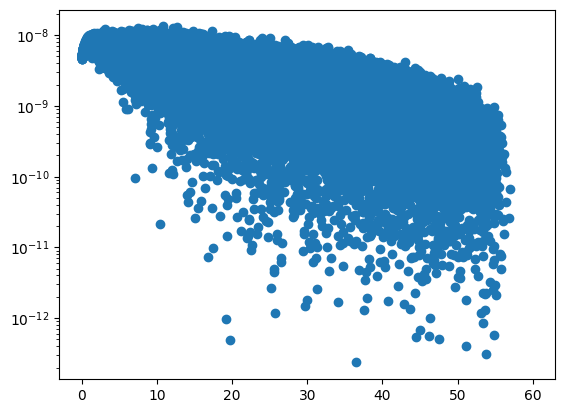

In [ ]:
import numpy as np
from numba import float64
from numba.experimental import jitclass


spec = [ ('N', float64[:]),
         ('a', float64[:]),
         ('phi', float64[:]),
         ('dphi', float64[:]),
         ('V', float64[:]) ]

@jitclass(spec)
class mukhanov_sasaki:
    '''
    Python class for numerically solving the Mukhanov-Sasaki equation beyond slow-roll
    approximations.

    Input parameters:
    N - efolds (array)
    a - scale factor (array)
    phi - background evolution of inflaton (array)
    dphi - background evolution of inflaton conjugate momentum (array)
    V - inflaton potential (array)
    '''
    def __init__(self, N, a, phi, dphi, V):

        self.N = N
        self.a = a
        self.phi = phi
        self.dphi = dphi
        self.V = V

    def efold_bounds(self, k):
        '''
        This method computes the efold times for which the modes are evolved. Defining
        the comoving horizon to be aH, the sub and superhorizon limits are given by
        100aH and 0.01aH. The function returns Nii and Nff which are efolds for which
        the sub and superhorizon conditions are satisfied for a given value of k. The
        function returns the real and imaginary components of the Mukhanov variable
        (uk and vk) and their efold derivatives (duk and dvk).
        '''
        H = np.sqrt( self.V/(3-0.5*self.dphi**2) )
        horizon = self.a*H
        initial = 100*horizon
        final = 0.01*horizon
        test_in = np.absolute(initial-k)
        test_fin = np.absolute(final-k)

        Nii = np.where( test_in==np.min(test_in) )[0][0]
        Nff = np.where( test_fin==np.min(test_fin) )[0][0]

        return Nii, Nff

    def mode_evolve(self, k, eps1, eta, d_eps, d_eta):
        '''
        This method computes the evolution of inflaton modes from Nii to Nff by solving
        the Mukhanov-Sasaki equation using fourth order Runge-Kutta (RK4) method.

        The derivatives of the Hubble flow parameters are passed as arguments and not
        evaluated inside the class since numpy.gradient is not supported by numba. One
        can explicitly define the derivative by writing a simple forward difference
        code inside the class if that helps.
        '''
        dN = self.N[1] - self.N[0]
        H = np.sqrt( self.V/(3-0.5*self.dphi**2) )

        Ni, Nf = self.efold_bounds(k)
        n = Nf - Ni + 1

        uk = np.zeros(n); duk = np.zeros(n)
        vk = np.zeros(n); dvk = np.zeros(n)

        #Bunch-Davies vacuum conditions
        uk[0] = 1/np.sqrt(2*k); duk[0] = 0
        vk[0] = 0; dvk[0] = -np.sqrt(k)/(0.01*np.sqrt(2)*k)

        '''
        This method returns the mode evolution, i.e., all the information of uk and others
        from Ni to Nf. The code can also be modified to produce simply the final values of
        uk and others for easier calculation of the power spectrum

        uk, duk, vk, dvk ----> uk[-1], duk[-1], vk[-1], dvk[-1]
        '''

        for i in range(n-1):

            f1 = -(1-eps1[Ni+i])*duk[i] - (k**2 /(self.a[Ni+i]*H[Ni+i])**2)*uk[i] - (1+eps1[Ni+i]-eta[Ni+i]) \
                *(eta[Ni+i]-2)*uk[i] + (d_eps[Ni+i]-d_eta[Ni+i])*uk[i]
            F1 = duk[i]
            f2 = -(1-eps1[Ni+i])*(duk[i]+0.5*f1*dN) - (k**2 /(self.a[Ni+i]*H[Ni+i])**2)*(uk[i]+0.5*F1*dN) \
                - (1+eps1[Ni+i]-eta[Ni+i])*(eta[Ni+i]-2)*(uk[i]+0.5*F1*dN) + (d_eps[Ni+i]-d_eta[Ni+i])*(uk[i]+0.5*F1*dN)
            F2 = duk[i] + 0.5*f1*dN
            f3 = -(1-eps1[Ni+i])*(duk[i]+0.5*f2*dN) - (k**2 /(self.a[Ni+i]*H[Ni+i])**2)*(uk[i]+0.5*F2*dN) \
                - (1+eps1[Ni+i]-eta[Ni+i])*(eta[Ni+i]-2)*(uk[i]+0.5*F2*dN) + (d_eps[Ni+i]-d_eta[Ni+i])*(uk[i]+0.5*F2*dN)
            F3 = duk[i] + 0.5*f2*dN
            f4 = -(1-eps1[Ni+i])*(duk[i]+f3*dN) - (k**2 /(self.a[Ni+i]*H[Ni+i])**2)*(uk[i]+F3*dN) \
                - (1+eps1[Ni+i]-eta[Ni+i])*(eta[Ni+i]-2)*(uk[i]+F3*dN) + (d_eps[Ni+i]-d_eta[Ni+i])*(uk[i]+F3*dN)
            F4 = duk[i] + f3*dN

            uk[i+1] = uk[i] + dN*(F1 + 2*F2 + 2*F3 + F4)/6
            duk[i+1] = duk[i] + dN*(f1 + 2*f2 + 2*f3 + f4)/6

            g1 = -(1-eps1[Ni+i])*dvk[i] - (k**2 /(self.a[Ni+i]*H[Ni+i])**2)*vk[i] - (1+eps1[Ni+i]-eta[Ni+i]) \
                *(eta[Ni+i]-2)*vk[i] + (d_eps[Ni+i]-d_eta[Ni+i])*vk[i]
            G1 = dvk[i]
            g2 = -(1-eps1[Ni+i])*(dvk[i]+0.5*g1*dN) - (k**2 /(self.a[Ni+i]*H[Ni+i])**2)*(vk[i]+0.5*G1*dN) \
                - (1+eps1[Ni+i]-eta[Ni+i])*(eta[Ni+i]-2)*(vk[i]+0.5*G1*dN) + (d_eps[Ni+i]-d_eta[Ni+i])*(vk[i]+0.5*G1*dN)
            G2 = dvk[i] + 0.5*g1*dN
            g3 = -(1-eps1[Ni+i])*(dvk[i]+0.5*g2*dN) - (k**2 /(self.a[Ni+i]*H[Ni+i])**2)*(vk[i]+0.5*G2*dN) \
                - (1+eps1[Ni+i]-eta[Ni+i])*(eta[Ni+i]-2)*(vk[i]+0.5*G2*dN) + (d_eps[Ni+i]-d_eta[Ni+i])*(vk[i]+0.5*G2*dN)
            G3 = dvk[i] + 0.5*g2*dN
            g4 = -(1-eps1[Ni+i])*(dvk[i]+g3*dN) - (k**2 /(self.a[Ni+i]*H[Ni+i])**2)*(vk[i]+G3*dN) \
                - (1+eps1[Ni+i]-eta[Ni+i])*(eta[Ni+i]-2)*(vk[i]+G3*dN) + (d_eps[Ni+i]-d_eta[Ni+i])*(vk[i]+G3*dN)
            G4 = dvk[i] + g3*dN

            vk[i+1] = vk[i] + dN*(G1 + 2*G2 + 2*G3 + G4)/6
            dvk[i+1] = dvk[i] + dN*(g1 + 2*g2 + 2*g3 + g4)/6

        return uk, duk, vk, dvk
        '''
This code solves the coarse-grained evolution of the inflaton and conjugate momentum
by solving the inflaton-Langevin equation using the exact expressions for noise.
V(phi) = V0(1 + xi - exp(-alpha*phi) - xi*exp(-beta*phi^2))^2
The inflaton-Langevin equations are simulated I-times and the loop is optimized
using the parallel-range (prange) function of numba.
'''
import numpy as np
from numpy import sqrt, exp
import time
import matplotlib.pyplot as plt
import numba


#location = "/home/rafid/Documents/codes/Stochastic_Inflation/"
#sys.path.append(location)

#from mukhanov_sasaki_class import mukhanov_sasaki

lamda = 10**(-12)
beta = 10**(-13)



dN = 0.001

@numba.njit
def V(x):
    return (lamda/24)*x**4+(beta/6)*x**3

@numba.njit
def dV(x):
    return (lamda/6)*x**3+(beta/2)*x**2

@numba.njit
def ddV(x):
    return (lamda/2)*x**2+(beta)*x

@numba.njit
def back_evolve(phi_in, efolds):
    N_test = efolds
    n = int(N_test/dN)
    phi = np.zeros(n); phi[0] = phi_in
    phi_M = np.zeros(n); phi_M[0] = -dV(phi_in)/V(phi_in)

    for i in range(n-1):
        K1 = dN*phi_M[i]
        L1 = dN*( -3*phi_M[i] + 0.5*phi_M[i]**3 - (3 - 0.5*phi_M[i]**2)*dV(phi[i])/V(phi[i]) )
        K2 = dN*(phi_M[i] + L1)
        L2 = dN*( -3*(phi_M[i] + L1) + 0.5*(phi_M[i] + L1)**3 - (3 - 0.5*(phi_M[i] + L1)**2)*dV(phi[i] + K1)/V(phi[i] + K1) )

        phi[i+1] = phi[i] + 0.5*(K1 + K2)
        phi_M[i+1] = phi_M[i] + 0.5*(L1 + L2)

    return phi, phi_M

@numba.njit(parallel=True)
def field_correlations(I, phi_, dphi_, eps_, eta_, d_eps_, d_eta_, efolds_):
    '''
    Pass d_eps and d_eta since numpy.gradient is not supported in numba
    '''
    N_end = efolds_
    N = np.linspace(0, N_end, int(N_end/dN))
    phi_bg = phi_; dphi_bg = dphi_
    potential = V(phi_bg)
    a0 = 0.217198
    a = a0*exp(N)

    eps1 = eps_
    eta = eta_
    d_eps = d_eps_
    d_eta = d_eta_
    H = sqrt(potential/(3-eps1))

    sigma = 5*10**-3 #set coarse-graining scale by k_sigma = sigma a*H
    NN = 10**4 #observable scale set an N=10, corresponding to point 10000 in efold grid
    N_run = np.linspace(0, 60, int(60/dN))
    delphi2 = np.zeros(len(N_run))
    delpi2 = np.zeros(len(N_run))
    NoiseAmp_phiphi = np.zeros(len(N_run))
    NoiseAmp_pipi = np.zeros(len(N_run))

    MS = mukhanov_sasaki(N_run, a, phi_bg, dphi_bg, potential)

    for j in range(len(N_run)):

        k = sigma*a[NN+j]*H[NN+j]
        Nii, Nff = MS.efold_bounds(k)
        Ni = dN*Nii
        Nf = dN*Nff
        n = Nff - Nii + 1
        N = np.linspace(Ni, Nf, n)

        uk, duk, vk, dvk = MS.mode_evolve(k, eps1, eta, d_eps, d_eta)

        '''
        Inflaton perturbations are related to the Mukhanov variable through the transformation
        Re_delphi = uk/a and Im_delphi = vk/a (similarly for conjugate momentum)
        '''

        Re_delphi = uk/a[Nii:Nff+1]
        Im_delphi = vk/a[Nii:Nff+1]

        Re_delpi = duk/a[Nii:Nff+1]
        Im_delpi = dvk/a[Nii:Nff+1]

        Pdelphidelphi = (k**3 /(2*np.pi**2))*( Re_delphi[-1]**2 + Im_delphi[-1]**2 )
        Pdelpidelpi = (k**3 /(2*np.pi**2))*( Re_delpi[-1]**2 + Im_delpi[-1]**2 )

        '''
        Define the noise amplitudes, which constitute the deterministic parts of the noise terms
        in the SDEs. The noise amplitudes are evaluated beforehand for all the Fourier modes of
        interest, determined by k_sigma = sigma a(N)*H(N) at each N.
        '''

        NoiseAmp_phiphi[j] = (1-eps1[NN+j])*Pdelphidelphi
        NoiseAmp_pipi[j] = (1-eps1[NN+j])*Pdelpidelpi

    phi_bg_run, dphi_bg_run = back_evolve(23.6, 60)

    for i in numba.prange(I):

        F = np.random.randn(len(N_run))/sqrt(dN)
        S = np.random.choice(np.array([-1, 1]), len(N_run))

        phi_cg = np.zeros(len(N_run))
        dphi_cg = np.zeros(len(N_run))
        phi_cg[0] = 23.6
        dphi_cg[0] = -dV(phi_cg[0])/V(phi_cg[0])

        for j in range(len(N_run)):

            k1 = dN*dphi_cg[j] + (dN*F[j] - S[j]*sqrt(dN))*sqrt(NoiseAmp_phiphi[j])
            l1 = dN*( -3*dphi_cg[j] + 0.5*dphi_cg[j]**3 - (3 - 0.5*dphi_cg[j]**2)*dV(phi_cg[j])/V(phi_cg[j]) ) \
                    + (dN*F[j] - S[j]*sqrt(dN))*sqrt(NoiseAmp_pipi[j])
            k2 = dN*(dphi_cg[j] + l1) + (dN*F[j] + S[j]*sqrt(dN))*sqrt(NoiseAmp_phiphi[j+1])
            l2 = dN*( -3*(dphi_cg[j] + l1) + 0.5*(dphi_cg[j] + l1)**3 - (3 - 0.5*(dphi_cg[j] + l1)**2) \
                     *dV(phi_cg[j] + k1)/V(phi_cg[j] + k1) ) +  (dN*F[j] + S[j]*sqrt(dN))*sqrt(NoiseAmp_pipi[j+1])

            phi_cg[j+1] = phi_cg[j] + 0.5*(k1 + k2)
            dphi_cg[j+1] = dphi_cg[j] + 0.5*(l1 + l2)

        delphi = phi_cg - phi_bg_run
        delpi = dphi_cg - dphi_bg_run
        delphi2 += delphi**2
        delpi2 += delpi**2

    delphi2 = delphi2/I
    delpi2 = delpi2/I

    return delphi2

if __name__ == "__main__":

    ti = time.time()

    print("Starting operation!")

    N_end = 70
    N = np.linspace(0, N_end, int(N_end/dN))
    phi_bg, dphi_bg = back_evolve(25, N_end)
    potential = V(phi_bg)
    eps1 = 0.5*dphi_bg**2
    eps2 = np.gradient(eps1, dN)/eps1
    eta = eps1 - 0.5*eps2
    d_eps = np.gradient(eps1, dN)
    d_eta = np.gradient(eta, dN)

    n_sim = 10**5
    delphi2 = field_correlations(n_sim, phi_bg, dphi_bg, eps1, eta, d_eps, d_eta, N_end)
    d_delphi2 = np.gradient(delphi2, dN)
    NN = 10**4
    P_zeta_stochastic = ( 0.5/(eps1[NN:]*(1-eps1[NN:])) )*(d_delphi2 - eps2[NN:]*delphi2)

    tf = time.time()
    print("Code execution time for " + str(n_sim) + "simulations: " + str(tf-ti) + " seconds.")

    plt.scatter(N[:60000], P_zeta_stochastic)
    plt.yscale('log')
    plt.show()